In [ ]:
# Advertisers use a variety of online marketing channels to reach consumers and they typically want to know how much each channel contributes to their marketing success. This is what is known as multi-channel attribution. In many cases, advertisers approach this problem using some simple heuristical models that often underestimate the importance of different marketing channels. In general, there are different types of attribution models:
# First Touch Conversion: A user's conversion is attributed to the first channels/touchpoints.
# Last Touch Conversion: A user's conversion is attributed to the last channels/touchpoints.
# Linear Touch Conversion: All channels/touchpoints are given equal credit to a user's conversion.
# Markov chains: A probabilistic model that represents the buyer's journey as a graph, with the nodes representing different channels/touchpoints, and the connecting lines being observed transitions between them. The number of times buyers have transitioned between two states is converted into a probability, which can then be used to measure the importance of each channel and the most likely channel paths to success.

In [1]:
# install ChannelAttribution lib
# https://pypi.org/project/ChannelAttribution/
# pip install --upgrade setuptools

In [129]:
# install MTA packages
# pip install Cython
# pip install ChannelAttribution

In [130]:
# load libs
import pandas as pd
import numpy as np
import plotly.express as px
from ChannelAttribution import *
import plotly.io as pio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [131]:
# load data
import os
from pathlib import Path 
MTA_data = Path(os.path.abspath(os.path.curdir)) / 'attribution data.csv'
df = pd.read_csv(MTA_data)
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [132]:
# setting up datetime format
df['time']=pd.to_datetime(df['time'])

In [133]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
# conversions = conversions[conversions['time']< pd.to_datetime("2023-12-30").date()]
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

/tmp/ipykernel_466/2819551866.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_466/2819551866.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
conversions.head()

,time,channel,conversion,conversion_value
0,2018-07-01,Facebook,135,835.0
1,2018-07-01,Instagram,69,438.5
2,2018-07-01,Online Display,75,463.5
3,2018-07-01,Online Video,42,257.5
4,2018-07-01,Paid Search,98,590.5


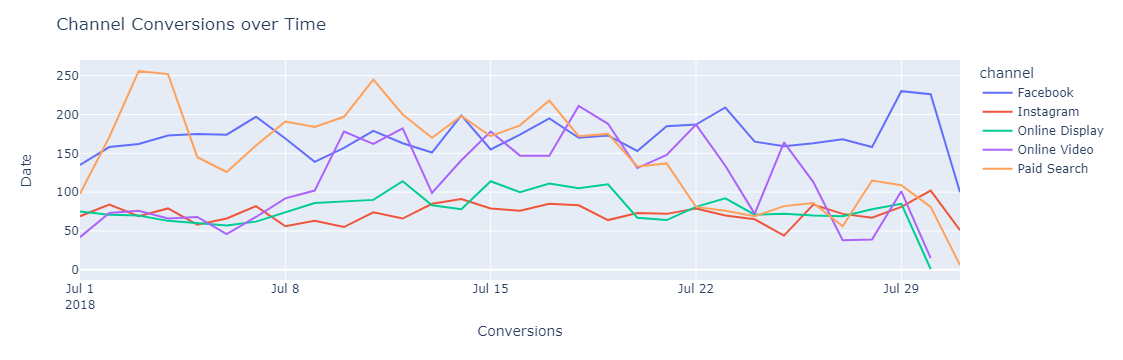

In [135]:
fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()

In [136]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1


In [137]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [92]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

,cookie,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,0,0.0
14,0003EfE37E93D0BC03iBhBBhF,0,0.0
15,00073CFE3FoFCn70fBhB3kfon,0,0.0
16,00079hhBkDF3k3kDkiFi9EFAD,0,0.0


In [138]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [139]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


In [140]:
#We will create a variable ‘path’ in the specific format required by the Attribution Model where the ordered channels are delimited by'>'
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [141]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)
attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.head()

,path,total_conversions,total_conversion_value,total_null
0,Facebook,2054,12857.0,32802
1,Facebook > Facebook,538,3295.0,7410
2,Facebook > Facebook > Facebook,230,1458.0,2066
3,Facebook > Facebook > Facebook > Facebook,85,542.5,751
4,Facebook > Facebook > Facebook > Facebook > Fa...,41,255.5,318


In [142]:
# using the ChannelAttribution package to create the attribution models
# H - First_Touch,Last_Touch,Linear_Touch
# M - based on the Markov chains

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [143]:
H.head()

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Facebook,5177.0,32283.0,5301.0,33143.5,5218.903371,32614.300094
1,Instagram,2329.0,14579.5,2244.0,14039.5,2265.179353,14171.723842
2,Online Display,2160.0,13419.0,2139.0,13298.5,2124.315256,13205.187068
3,Online Video,3216.0,20225.5,3408.0,21418.0,3349.403371,21045.330408
4,Paid Search,4757.0,29724.0,4547.0,28331.5,4681.198650,29194.458588


In [144]:
M.head()

,channel_name,total_conversions,total_conversion_value
0,Facebook,5258.017942,32826.061993
1,Instagram,3471.060425,21711.207332
2,Online Video,2877.668461,18065.749695
3,Paid Search,3984.203191,24861.580609
4,Online Display,2048.049981,12766.400371


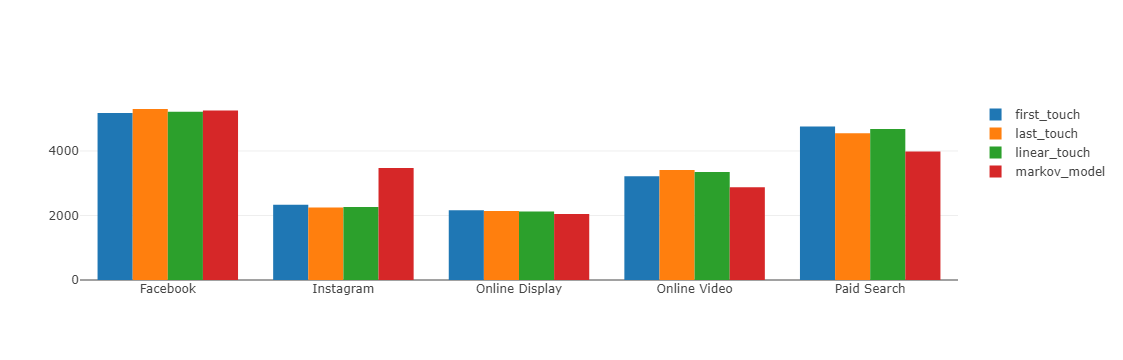

In [145]:
# plotting the chart to show impact of different channels for four types of the Attribution models (H,F)
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions", "linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

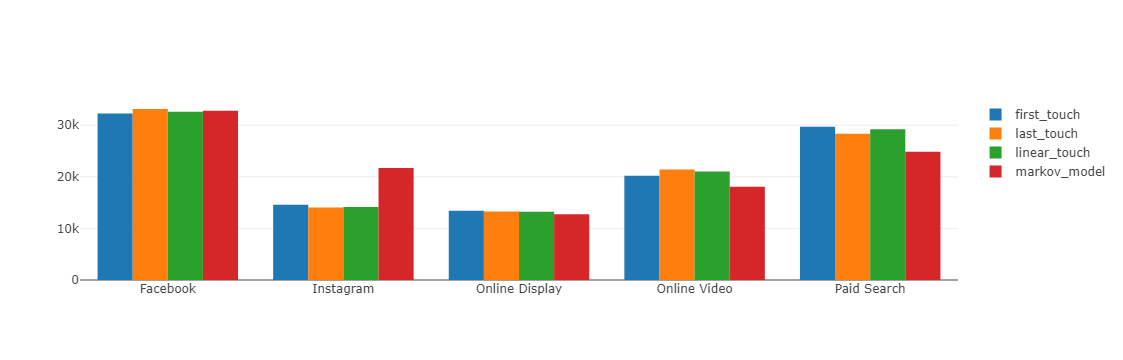

In [146]:
# Similar to the total conversions bar chart, a revenue bar chart can be created highlighting the revenue attributed to each channel.
R2=R[["channel_name","first_touch_value","last_touch_value","linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R2=pd.melt(R2, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum", x = R2.channel_name, y = R2.value,
             transforms = [dict(type = "groupby",groups = R2.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)

In [147]:
# To get an idea of how the different channels affect a user's journeys we can also look at the transition probability matrix, which can be visualized in a heatmap.
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [148]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Facebook'),
  Text(3.5, 0, 'Instagram'),
  Text(4.5, 0, 'Online Display'),
  Text(5.5, 0, 'Online Video'),
  Text(6.5, 0, 'Paid Search')])

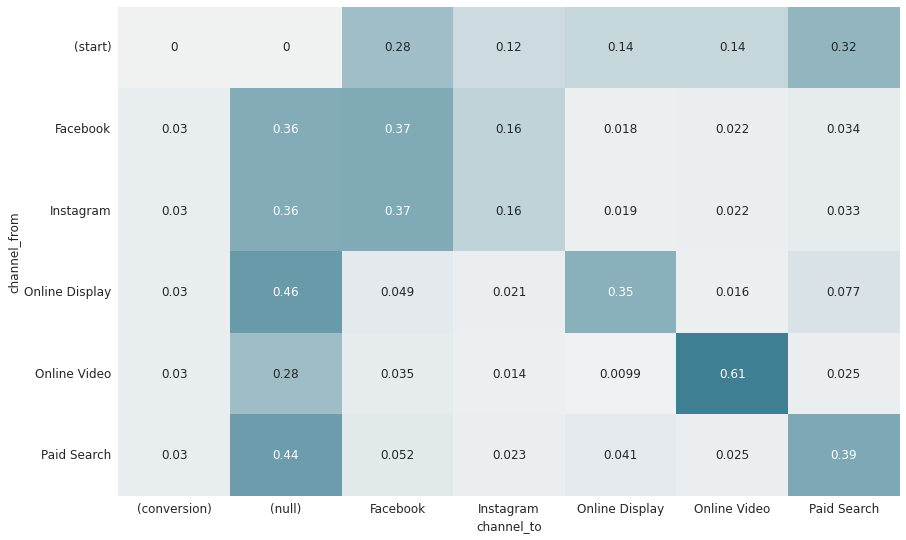

In [149]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)